In [1]:
#$ Imports
import os
import sys
import json
from datetime import datetime
from IPython import display

import random
import numpy as np
import scipy as sc
from scipy import stats
import pandas as pd
import xarray as xr
import cftime
from dask.diagnostics import ProgressBar
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean as cmo

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

import utils
from utils import settings

In [2]:
#$ Global variables
with open("~/s2s/paths.json") as paths_json:
    PATHS = json.load(paths_json)
with open("~/s2s/globals.json") as globals_json:
    GLOBALS = json.load(globals_json)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    print(f"Using cuda device {torch.cuda.get_device_name(0)}")

plt.style.use('bmh')

$WORK/conda-envs/s2s/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif"
# })

plt.rcParams['mathtext.fontset'] = 'custom'

## Computing and saving tensors for different lags

In [4]:
def get_data_directly(tau, icoord):
    data_path = os.path.join(PATHS['full_globe'], 'data', f'tau_{tau}')
    network_path = os.path.join(PATHS['full_globe'], f'networks/tau_{tau}/loc_{icoord}')
    predictions_path = os.path.join(PATHS['full_globe'], f'predictions/tau_{tau}/loc_{icoord}')
    
    # Get lat and lon indices
    icoords_list = np.load(os.path.join(data_path, 'icoords.npy'))
    ilat, ilon = icoords_list[icoord]
    lat, lon = utils.helpers.get_lat_lon_from_icoord(icoord)
    point = {'lat': lat, 'lon': lon}
    
    # Target data
    y_test_darray = xr.open_dataarray(os.path.join(data_path, 'y_test.nc'))
    y_test_tensor = torch.load(os.path.join(data_path, 'y_test_tensor.pt'))
    target_z = y_test_tensor.numpy()
    target_z = target_z[:, ilat, ilon]
    
    # Select target values at location
    pred_mean_z = np.load(os.path.join(predictions_path, 'pred_mean_z.npy'))
    pred_logvar_z = np.load(os.path.join(predictions_path, 'pred_logvar_z.npy'))
    
    # Make stuff into dataarrays
    time = xr.CFTimeIndex(y_test_darray['time'].values)
    target_z = xr.DataArray(target_z, dims=('time',), coords={'time':time})
    pred_mean_z = xr.DataArray(pred_mean_z, dims=('time',), coords={'time':time})
    pred_logvar_z = xr.DataArray(pred_logvar_z, dims=('time',), coords={'time':time})

    # Get damped persistence predictions as well
    y_scaler = utils.processing.load_standardizer(data_path, 'y')
    y_scaler = y_scaler.sel(lat=lat, lon=lon, method='nearest')
    
    # dp_model = utils.baselines.DampedPersistenceModel()
    # dp_model.fit_to_training_data(point, tau=tau, T=5, s=5, quick_train=True)
    
    # # Training features are unstandardized (but mean 0) shifted targets:
    # X_test_dp, y_test_dp = utils.baselines.get_dp_data(
    #     1301, '013', point, tau=tau, T=5, s=5)
    
    # dp_pred = dp_model.predict(X_test_dp)
    # dp_pred = xr.DataArray(dp_pred, coords={'time': time})
    # dp_pred_z = utils.processing.standardize(dp_pred, y_scaler)

    # Get damped persistence predictions as well    
    dp_pred_z = xr.open_dataarray(os.path.join(PATHS['full_globe'], f'predictions/tau_{tau}/dp_pred.nc'))
    dp_pred_z = dp_pred_z.sel(lat=lat, lon=lon, method='nearest')

    return target_z, pred_mean_z, pred_logvar_z, dp_pred_z

## Plotting

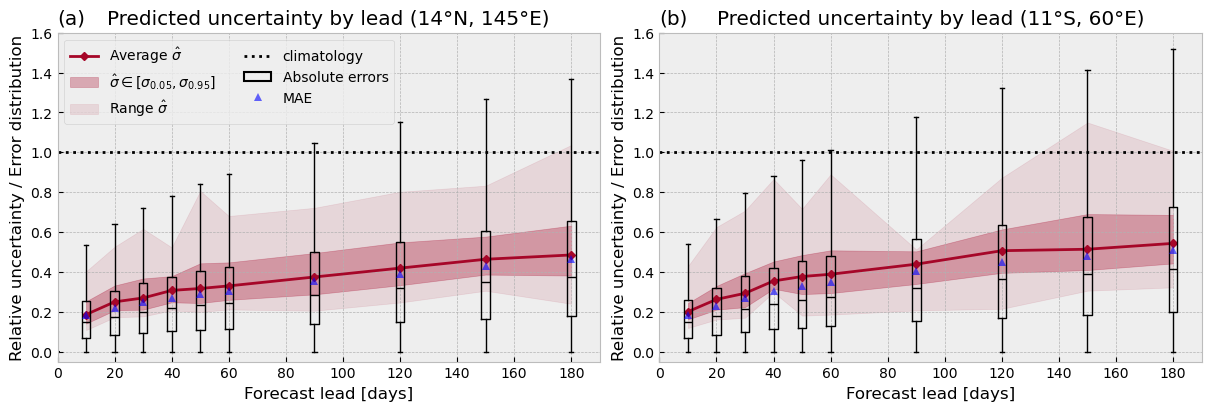

In [17]:
taus = np.array([10, 20, 30, 40, 50, 60, 90, 120, 150, 180])
icoords = [4710, 3282]

fig, axes = plt.subplots(ncols=2, figsize=(12,4), layout='constrained')

for j, (ax, icoord) in enumerate(zip(axes, icoords)):
    lat, lon = utils.helpers.get_lat_lon_from_icoord(icoord)
    lat, lon = np.round(lat), np.round(lon)
    target_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'target_all.nc'))
    pred_mean_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'pred_mean_all.nc'))
    pred_logvar_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'pred_logvar_all.nc'))
    dp_pred_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'dp_pred_all.nc'))

    pred_std_all = np.sqrt(np.exp(pred_logvar_all))

    for i, tau in enumerate(taus):
        network_path = os.path.join(PATHS['full_globe'], f'networks/tau_{tau}/loc_{icoord}')
        residual_scaler = residual_scaler = utils.processing.load_standardizer(network_path, 'residual')
        pred_std_all[i, :] = residual_scaler['mean'] + residual_scaler['std'] * pred_std_all[i, :]

    # Compute relative values
    clim_std = target_all.std(dim='time')
    relative_std = pred_std_all / clim_std
    relative_error = np.abs(target_all - pred_mean_all) / clim_std

    # Ranges of std
    std_avg = relative_std.mean(dim='time')
    q_min = 0.05
    std_lower = relative_std.quantile(q_min, dim='time')
    std_upper = relative_std.quantile(1-q_min, dim='time')

    # Plotting
    std_avg.plot(ax=ax, marker='D', color='C1', ms=4, label=r'Average $\hat{\sigma}$')
    ax.fill_between(
        taus, std_upper, std_lower, alpha=0.3, color='C1',
        label=r'$\hat\sigma \in [\sigma_{{{}}}, \sigma_{{{}}}]$'.format(q_min, 1-q_min)
    )
    ax.fill_between(
        taus, relative_std.min(dim='time'), relative_std.max(dim='time'),
        # taus, relative_std.quantile(0.005, dim='time'), relative_std.quantile(0.995, dim='time'),
        alpha=0.1, color='C1',
        label=r'Range $\hat{\sigma}$'
    )
    # Boxplots
    df = relative_error.to_pandas().transpose()
    boxdata = []
    for tau in df.columns:
        data = df[tau]
        data = data[~np.isnan(data)]
        boxdata.append(data)
    ax.boxplot(
        boxdata, positions=taus.tolist(), widths=3,
        showfliers=False, 
        medianprops={'color': 'k',},
        showmeans=True,
        meanprops={'marker': '^', 'ms': 6, 'mfc': 'b', 'mew': 0, 'alpha': 0.6}
    )

    if lat >= 0:
        title = f'Predicted uncertainty by lead ({int(lat)}\u00b0N, {int(lon)}\u00b0E)'
    else:
        title = f'Predicted uncertainty by lead ({-int(lat)}\u00b0S, {int(lon)}\u00b0E)'
    
    # Climatology
    ax.plot([0, 190], np.ones(2), color='k', ls=':', label='climatology')
    ax.set(
        title=title,
        xlabel='Forecast lead [days]',
        ylabel='Relative uncertainty, absolute errors',
        xlim=(0,190),
        ylim=(-0.05, 1.6),
    );
    
    ax.set_xticks(np.arange(0, 190, 20), labels=np.arange(0, 190, 20))

axes[0].hist([], histtype='step', color='k', lw=1.5, label='Absolute errors')
axes[0].plot([], ls='', marker='^', ms=6, mfc='b', mew=0, alpha=0.6, label='MAE')

axes[0].legend(ncols=2)
axes[0].set_title(f"(a)", loc='left')
axes[1].set_title(f"(b)", loc='left')

plt.savefig('std_by_lag.pdf', dpi=300, bbox_inches='tight')

## Changes in range of predicted uncertainties

In [100]:
ranges = []
ranges_90 = []

for j, (ax, icoord) in enumerate(zip(axes, icoords)):
    lat, lon = utils.helpers.get_lat_lon_from_icoord(icoord)
    target_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'target_all.nc'))
    pred_mean_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'pred_mean_all.nc'))
    pred_logvar_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'pred_logvar_all.nc'))
    dp_pred_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'dp_pred_all.nc'))

    pred_std_all = np.sqrt(np.exp(pred_logvar_all))

    for i, tau in enumerate(taus):
        network_path = os.path.join(PATHS['full_globe'], f'networks/tau_{tau}/loc_{icoord}')
        residual_scaler = residual_scaler = utils.processing.load_standardizer(network_path, 'residual')
        pred_std_all[i, :] = residual_scaler['mean'] + residual_scaler['std'] * pred_std_all[i, :]

    # Compute relative values
    clim_std = target_all.std(dim='time')
    relative_std = pred_std_all / clim_std
    relative_error = np.abs(target_all - pred_mean_all) / clim_std
    
    ranges.append(relative_std.max(dim='time') - relative_std.min(dim='time'))
    ranges_90.append(relative_std.quantile(0.95, dim='time') - relative_std.quantile(0.05, dim='time'))

In [101]:
ranges_90

[<xarray.DataArray (tau: 10)>
 array([0.11134329, 0.12422147, 0.15637445, 0.131219  , 0.19900751,
        0.18800715, 0.20710671, 0.21479003, 0.19050106, 0.25031514])
 Coordinates:
   * tau      (tau) int64 10 20 30 40 50 60 90 120 150 180,
 <xarray.DataArray (tau: 10)>
 array([0.08220871, 0.11862496, 0.17016842, 0.13699718, 0.19566431,
        0.21448644, 0.16373845, 0.21773454, 0.28081422, 0.24324628])
 Coordinates:
   * tau      (tau) int64 10 20 30 40 50 60 90 120 150 180]

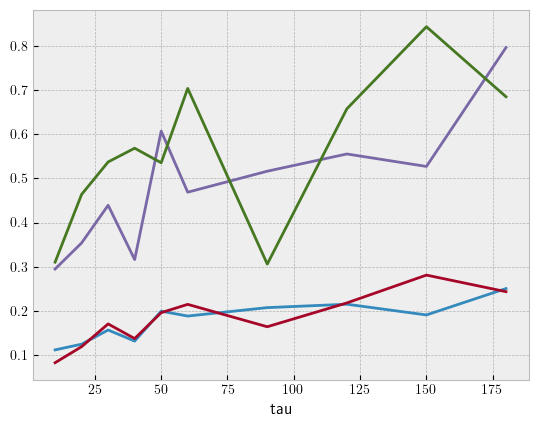

In [102]:
ranges_90[0].plot()
ranges_90[1].plot()

ranges[0].plot()
ranges[1].plot()

In [99]:
print(stats.linregress(taus, ranges_90[0], alternative='greater').pvalue)
print(stats.linregress(taus, ranges_90[1], alternative='greater').pvalue)

print(stats.linregress(taus, ranges[0], alternative='greater').pvalue)
print(stats.linregress(taus, ranges[1], alternative='greater').pvalue)

0.00017790469135305073
0.001942253013518494
0.0019084196575218872
0.02703607855859711


---

---